In [57]:
%load_ext autoreload
%autoreload 2

import os, sys, re, datetime, random, gzip, json, copy
import tqdm
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from itertools import accumulate
import argparse
from time import time
from math import ceil
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score, top_k_accuracy_score, roc_auc_score
from sklearn.utils import class_weight

PROJ_PATH = Path(os.path.join(re.sub("/TS-IDS.*$", '', os.getcwd()), 'TS-IDS'))
print(f'PROJ_PATH={PROJ_PATH}')
sys.path.insert(1, str(PROJ_PATH))
sys.path.insert(1, str(PROJ_PATH/'src'))
import utils

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PROJ_PATH=/home/hoang/github/TS-IDS


In [85]:
def read_output(ds, model):
    # label mapping
    g_data = pd.read_pickle(f'../datasets/{ds[1]}.pkl')
    label2idx = g_data['label2idx']
    idx2label = {j:i for i,j in label2idx.items()}
    # ouput df
    df = pd.read_csv(f'../output/{model}_{ds[0]}.csv')
    prob_cnames = [c for c in df.columns if c.startswith('probs')]
    df['pred'] = df[prob_cnames].values.argmax(axis=1)
    df['True label'] = df['gts'].map(idx2label)
    df['Predicted label'] = df['pred'].map(idx2label)
    return df

def calc_auc(gts, probs, avg_type='macro', binary=False):
    if binary:
        auc = roc_auc_score(gts, preds)
    else: 
        auc = roc_auc_score(
            gts, 
            probs, 
            average=avg_type, 
            multi_class='ovo', 
        )
    return auc

def calc_f1(gts, preds, avg_type='macro'):
    score = f1_score(gts, preds, average=avg_type, zero_division=0)
    return score

def calc_accuracy(gts, preds):
    acc = accuracy_score(gts, preds)
    return acc

def plot_confusion_matrix(df_test):
    # https://seaborn.pydata.org/tutorial/color_palettes.html
    fontsize = 14
    fig, ax = plt.subplots(figsize=(10,7))
    tdf = df_test.pivot_table(
        index='True label', columns='Predicted label', values='probs_0', aggfunc='count', fill_value=0.0)
    g = sns.heatmap(
        tdf, ax=ax, annot=True, fmt=".0f", cmap="flare", linewidth=.5, 
        xticklabels=tdf.columns, yticklabels=tdf.columns)
    g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=fontsize)
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=fontsize)
    g.set_xlabel(g.get_xlabel(), fontsize=fontsize)
    g.set_ylabel(g.get_ylabel(), fontsize=fontsize)
    plt.show()

('nf_bot_binary', 'NF-BoT-IoT_graph_binary')


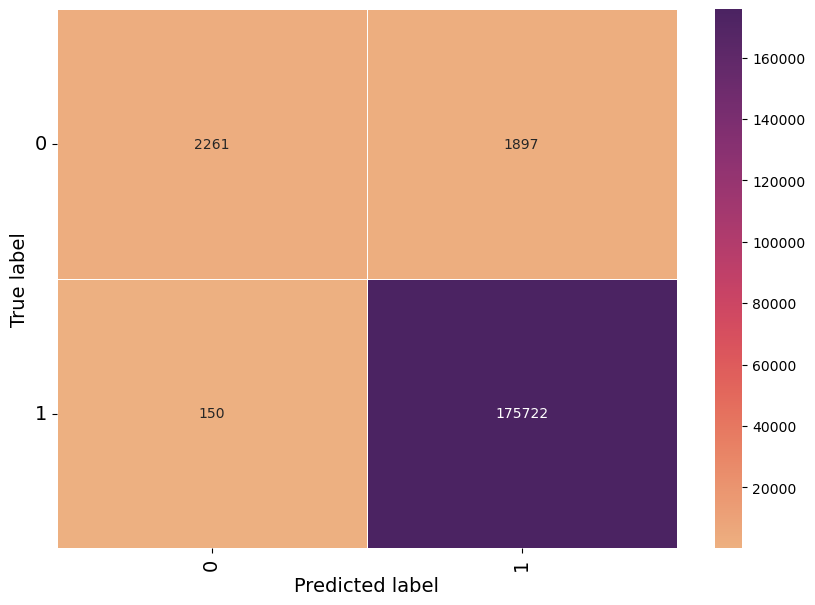



('nf_bot_multi', 'NF-BoT-IoT_graph_multi')


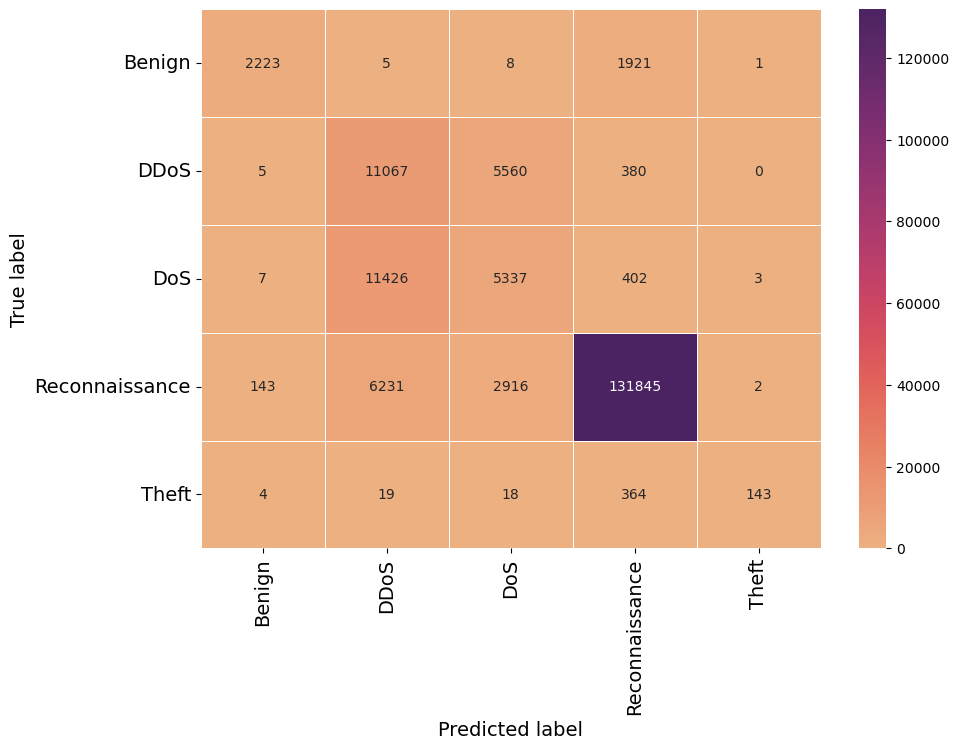



('nf_ton_binary', 'NF-ToN-IoT_graph_binary')


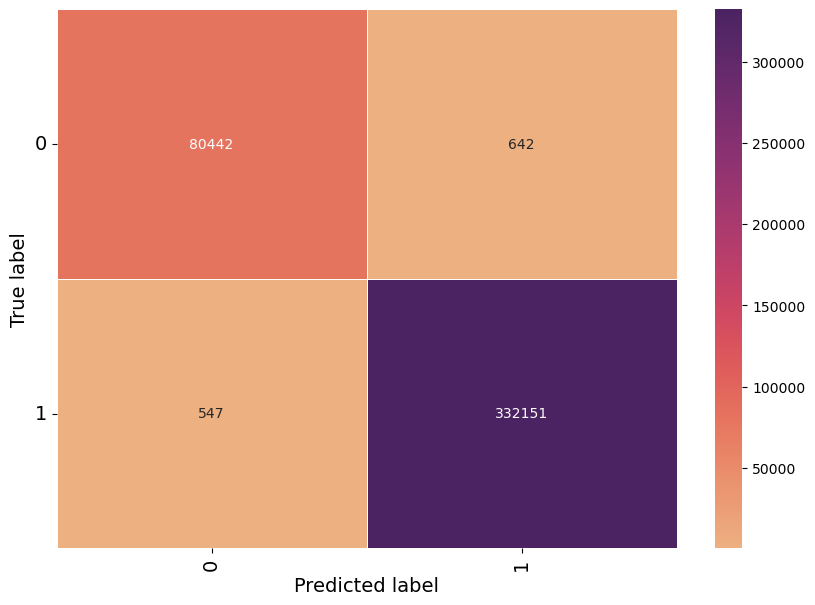



('nf_ton_multi', 'NF-ToN-IoT_graph_multi')


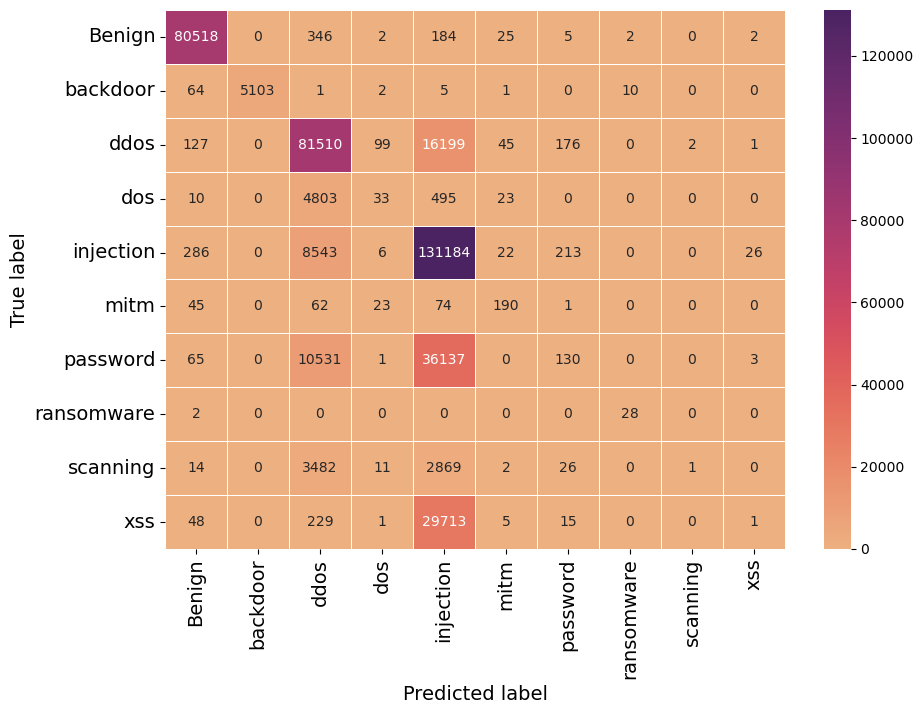

In [95]:
datasets = [
    ('nf_bot_binary', 'NF-BoT-IoT_graph_binary'),
    ('nf_bot_multi', 'NF-BoT-IoT_graph_multi'),
    ('nf_ton_binary', 'NF-ToN-IoT_graph_binary'),
    ('nf_ton_multi', 'NF-ToN-IoT_graph_multi'),
]
model = 'xgb'
results = {
    'model': [],
    'dataset': [],
    'acc': [],
    'auc': [],
    'f1_macro': [],
    'f1_micro': [],
}
for ds in datasets:
    print(ds)
    df = read_output(ds, model)
    df_test = df[df['tvt']=='test']
    gts = df_test['gts'].values
    preds = df_test['pred'].values
    probs_cnames = [c for c in df_test.columns if c.startswith('probs_')]
    if len(probs_cnames) == 2:
        probs = df_test['probs_1']
        binary = True
    else:
        probs = df_test[probs_cnames].values
        binary = False
    
    acc = calc_accuracy(gts, preds)
    auc = calc_auc(gts, probs, binary=binary)
    f1_macro = calc_f1(gts, preds, avg_type='macro')
    f1_micro = calc_f1(gts, preds, avg_type='micro')
    
    results['model'].append(model)
    results['dataset'].append(ds)
    results['acc'].append(acc)
    results['auc'].append(auc)
    results['f1_macro'].append(f1_macro)
    results['f1_micro'].append(f1_micro)
    plot_confusion_matrix(df_test)
    
    print('\n')

In [96]:
df_res = pd.DataFrame(data=results)

In [97]:
df_res

,model,dataset,acc,auc,f1_macro,f1_micro
0,xgb,"(nf_bot_binary, NF-BoT-IoT_graph_binary)",0.988630,0.771459,0.841297,0.988630
1,xgb,"(nf_bot_multi, NF-BoT-IoT_graph_multi)",0.836611,0.933073,0.574648,0.836611
2,xgb,"(nf_ton_binary, NF-ToN-IoT_graph_binary)",0.997127,0.995219,0.995439,0.997127
3,xgb,"(nf_ton_multi, NF-ToN-IoT_graph_multi)",0.721873,0.939991,0.485851,0.721873


In [98]:
df.head()

,probs_0,probs_1,probs_2,probs_3,probs_4,probs_5,probs_6,probs_7,probs_8,probs_9,gts,tvt,pred,True label,Predicted label
0,0.997096,3.639415e-07,0.000512,0.000003,0.002188,0.000121,0.000015,6.504833e-08,0.000008,0.000056,0,train,0,Benign,Benign
1,0.999591,2.028457e-05,0.000031,0.000008,0.000219,0.000039,0.000041,5.308652e-06,0.000024,0.000022,0,train,0,Benign,Benign
2,0.999591,2.028457e-05,0.000031,0.000008,0.000219,0.000039,0.000041,5.308652e-06,0.000024,0.000022,0,train,0,Benign,Benign
3,0.999869,1.432071e-05,0.000002,0.000002,0.000071,0.000029,0.000002,2.046886e-06,0.000002,0.000006,0,train,0,Benign,Benign
4,0.999591,2.028457e-05,0.000031,0.000008,0.000219,0.000039,0.000041,5.308652e-06,0.000024,0.000022,0,train,0,Benign,Benign
